# Boltzmann Machine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def sigmoid(x):
    return 1. / ( 1 + np.exp(-x) )

In [46]:
class BM:
    def __init__(self, N, n_input=1):
        """ N: total number of neurons. """
        self.N = N
        self.Nin = n_input

        self.W = np.random.normal(loc=0.0, scale=0.2, size=(self.N, self.N) )
        self.W = 0.5*( self.W + self.W.T )
        np.fill_diagonal( self.W, 0. )
        self.b = np.zeros( shape=(self.N, 1) )
        
        self._reinit_s()

        self.E = self.energy()

    def energy(self):
        return -0.5*self.s.T @ ( self.W @ self.s) - self.b.T @ self.s

    def _Gibbs_sampling(self, T, start_idx, end_idx):
        for n in range(start_idx,end_idx):
            # tentative transition
            self.s[n] = 1. - self.s[n]
            E_new = self.energy()
            deltaE = self.E - E_new
            proba = 1. / (1. + np.exp( -deltaE/T ) )
            if np.random.random() < proba :
                # we accept the transition
                self.E = E_new
            else:
                # revert the transition
                self.s[n] = 1. - self.s[n]
                
    def _dynamics(self, n_iter, annealing_schedule, start_idx, end_idx):
        for T in annealing_schedule():
            for _ in range(n_iter):
                self._Gibbs_sampling( T, start_idx, end_idx )
            
    def _reinit_s(self):
        s_ = np.random.random( size=(self.N, 1) )
        self.s = np.array( s_ >= 0.5, dtype=np.float )
            
    def clamp_input(self, p):
        """ clamp inputs to values given by p """
        self.s[:self.Nin] = np.expand_dims( p, axis=1 )

    def train(self, input_data, learning_rate, n_iter, annealing_schedule):
        """ WARNING: input_data is n_feature-by-n_samples!!! """
        
        # positive phase
        n_samples = float( input_data.shape[1] )
        Wupdates = np.zeros_like(self.W)
        bupdates =  np.zeros_like(self.b)
        counter = 0
        for col in range( input_data.shape[1] ):
            #if counter % 100 == 0:
            #    print('iteration: ', counter)
            #counter += 1
            self._reinit_s()
            data_sample = input_data[:,col]

            self.clamp_input( data_sample )
            
            self._dynamics(n_iter, annealing_schedule, self.Nin, self.N )
            
            Wupdates += np.outer( self.s, self.s )
            bupdates += self.s
            
        self.W += (learning_rate/n_samples)*Wupdates
        np.fill_diagonal( self.W, 0. )
        self.b += (learning_rate/n_samples)*bupdates

        # negative phase
        n_samples = 100.
        Wupdates = np.zeros_like(self.W)
        bupdates =  np.zeros_like(self.b)
        for _ in range(int(n_samples)):
            self._reinit_s()
            self._dynamics(n_iter, annealing_schedule, 0, self.N )
            Wupdates += np.outer( self.s, self.s )
            bupdates += self.s

        self.W -= (learning_rate/n_samples)*Wupdates
        np.fill_diagonal( self.W, 0. )
        self.b -= (learning_rate/n_samples)*bupdates

    def dream(self, hidden_state, annealing_schedule, n_iter = 10 ):
        self.s[self.Nin:] = hidden_state
        self._dynamics(n_iter, annealing_schedule, 0, self.Nin )
        return self.s[:self.Nin]


## Make a simple test



In [34]:
bm = BM(4,2)
targetW = np.array([[ 0.,          0.,          0.6,         0.],
                    [ 0.,          0.,          0.,          0.3],
                    [ 0.6,         0.,          0.,          -0.3],
                    [ 0.,          0.3,         -0.3,        0.]])
bm.W = np.copy(targetW)
print(targetW)

[[ 0.   0.   0.6  0. ]
 [ 0.   0.   0.   0.3]
 [ 0.6  0.   0.  -0.3]
 [ 0.   0.3 -0.3  0. ]]


#### Debugging your energy computation

The idea here is that we fix a known model, i.e. a matrix of weights and biases:

$ W = \begin{matrix}
   0 & 0 & 2 & 0 \\
   0 & 0 & 0 & 1 \\
   2 & 0 & 0 & -1 \\
   0 & 1 & -1 & 0 \end{matrix} $
   
$ \mathbf{b} = \mathbf{0} $

N.B. this example is taken from [slide 35](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec11.pdf).

We can compute the probability distribution induced by $W,\mathbf{b}$ by hand and verify that our implementation respects it. 

The function below should reproduce the exact table from the slide.
   

In [35]:
def generate_table(bm, total_partition_function = 39.7, print_flag = False):

    partition_function_check_value = 0.
    marginal_sums = np.empty(shape=(4,1))
    for i in range(1,-1,-1):
        for j in range(1,-1,-1):
            marginal_sum = 0.
            for t in range(1,-1,-1):
                for k in range(1,-1,-1):
                    bm.s[:] = np.array([i, j, t, k]).reshape(4,1)
                    if print_flag:
                        print( i, j, t, k, float(-bm.energy()), np.exp(-float(bm.energy()) ), np.exp(-float(bm.energy()) )/total_partition_function )
                    marginal_sum += np.exp(-float(bm.energy()) )
            #print ( marginal_sum )
            marginal_sums[i*2 + j] = marginal_sum
            partition_function_check_value += marginal_sum
            
    if print_flag:
        print('')
        print( 'partition function: ', partition_function_check_value )
        print('')
        for i in range(1,-1,-1):
            for j in range(1,-1,-1):
                print('proba( v = [', i, ',', j, '] ) = ', marginal_sums[i*2 + j]/partition_function_check_value)
            
    return partition_function_check_value

In [36]:
tot_partition_function = generate_table(bm, 0., False)
generate_table(bm, tot_partition_function, True)

1 1 1 1 0.6 1.82211880039 0.0946223377024
1 1 1 0 0.6 1.82211880039 0.0946223377024
1 1 0 1 0.3 1.34985880758 0.0700979518534
1 1 0 0 -0.0 1.0 0.0519298399655
1 0 1 1 0.29999999999999993 1.34985880758 0.0700979518534
1 0 1 0 0.6 1.82211880039 0.0946223377024
1 0 0 1 -0.0 1.0 0.0519298399655
1 0 0 0 -0.0 1.0 0.0519298399655
0 1 1 1 -0.0 1.0 0.0519298399655
0 1 1 0 -0.0 1.0 0.0519298399655
0 1 0 1 0.3 1.34985880758 0.0700979518534
0 1 0 0 -0.0 1.0 0.0519298399655
0 0 1 1 -0.3 0.740818220682 0.0384705716435
0 0 1 0 -0.0 1.0 0.0519298399655
0 0 0 1 -0.0 1.0 0.0519298399655
0 0 0 0 -0.0 1.0 0.0519298399655

partition function:  19.2567510446

proba( v = [ 1 , 1 ] ) =  [ 0.31127247]
proba( v = [ 1 , 0 ] ) =  [ 0.26857997]
proba( v = [ 0 , 1 ] ) =  [ 0.22588747]
proba( v = [ 0 , 0 ] ) =  [ 0.19426009]


19.256751044581254

#### Test sampling / dreaming procedure

The idea is similar to the above: given a model $W,\mathbf{b}$ we can compute the induced probability distribution.
In particular, we compute the probability distribution _given a fixed hidden state_.

Then, we can run the sampling method of our Boltzmann Machine, and make sure that it respects that probability distribution.

In [37]:
n_samples = 1000

X = np.empty(shape=(2,n_samples))
for i in range(n_samples):
    r = np.random.random() 
    if r < 0.311:
        X[:,i] = np.array([1,1])             
    elif r < 0.311 + 0.269:
        X[:,i] = np.array([1,0])
    elif r < 1. - 0.194:
        X[:,i] = np.array([0,1])
    else:          
        X[:,i] = np.array([0,0])

In [38]:
sums = []
for i in range(n_samples):
    sums.append(np.sum(X[:,i]))
reference_hist = np.histogram(sums, bins=np.array([-0.5,0.5,1.5,2.5]))

In [39]:
def annealing_schedule():
    T_schedule = [20., 15., 10., 5., 1., 1.]
    n_repeat = 2
    for T in T_schedule:
        for _ in range(n_repeat):
            yield T

In [40]:
def check_sampling_procedure( bm, n_samples, annealing_schedule, hidden_state = None, n_dream_iter = 10 ):
    Y = np.empty(shape=(2,n_samples))
    for i in range(n_samples):
        if hidden_state is None:
            hidden_state = np.random.randint(low=0,high=2,size=(2,1))
        Y[:,i] = bm.dream(hidden_state, annealing_schedule, n_dream_iter).reshape(2,)

    sums = []
    for i in range(n_samples):
        sums.append(np.sum(Y[:,i]))

    hist = np.histogram(sums, bins=np.array([-0.5,0.5,1.5,2.5]))
    return hist

In [41]:
print (bm.W)
print(targetW)
print(bm.b)

[[ 0.   0.   0.6  0. ]
 [ 0.   0.   0.   0.3]
 [ 0.6  0.   0.  -0.3]
 [ 0.   0.3 -0.3  0. ]]
[[ 0.   0.   0.6  0. ]
 [ 0.   0.   0.   0.3]
 [ 0.6  0.   0.  -0.3]
 [ 0.   0.3 -0.3  0. ]]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [43]:
tot_conditioned_partition = 1.82211880039 + 1.34985880758 + 1.0 + 0.740818220682
marginals = np.array([0.740818220682, (1.34985880758 + 1.0), 1.82211880039])
marginals /= tot_conditioned_partition
print(marginals)
print( check_sampling_procedure(bm, 1000, annealing_schedule, np.array([1,1]).reshape(2,1), 20) )

[ 0.15079361  0.47831396  0.37089243]
(array([164, 467, 369]), array([-0.5,  0.5,  1.5,  2.5]))


In [ ]:
print( reference_hist[0]/1000. )
n_samples = 4000
check = check_sampling_procedure(bm, n_samples, annealing_schedule)
print( check[0]/float(n_samples) )

# Finally train the model!

In [51]:
bm = BM(4,2)

In [52]:
print(targetW)
print(bm.W)

[[ 0.   0.   0.6  0. ]
 [ 0.   0.   0.   0.3]
 [ 0.6  0.   0.  -0.3]
 [ 0.   0.3 -0.3  0. ]]
[[ 0.         -0.05453654  0.18892112 -0.10763678]
 [-0.05453654  0.          0.24338988  0.14848591]
 [ 0.18892112  0.24338988  0.          0.01219704]
 [-0.10763678  0.14848591  0.01219704  0.        ]]


In [53]:
W_history = []
W_history.append(bm.W)
n_epochs = 60
vals = []
print('>> error ', np.sum(np.sum((targetW - bm.W)**2)) )
for epoch_n in range(n_epochs):
    print('====== epoch ', epoch_n, '=======')
    bm.train( X, 0.01, 20, annealing_schedule )
    W_history.append(np.copy(bm.W))
    vals.append(np.sum(np.sum((targetW - bm.W)**2)))
    print('>> error ', np.sum(np.sum((targetW - bm.W)**2)) )


>> error  0.726415803455
====== epoch  0 =======
>> error  0.725726490857
====== epoch  1 =======
>> error  0.724564548534
====== epoch  2 =======
>> error  0.722976265618
====== epoch  3 =======
>> error  0.721326261552
====== epoch  4 =======
>> error  0.720931143753
====== epoch  5 =======
>> error  0.720328071517
====== epoch  6 =======
>> error  0.720487347837
====== epoch  7 =======
>> error  0.719603276294
====== epoch  8 =======
>> error  0.719871175315
====== epoch  9 =======
>> error  0.719780324293
====== epoch  10 =======
>> error  0.716900171059
====== epoch  11 =======
>> error  0.714406885872
====== epoch  12 =======
>> error  0.713631060528
====== epoch  13 =======
>> error  0.712964187644
====== epoch  14 =======
>> error  0.711119496261
====== epoch  15 =======
>> error  0.709853681588
====== epoch  16 =======
>> error  0.708198748995
====== epoch  17 =======
>> error  0.706480557245
====== epoch  18 =======
>> error  0.703991953394
====== epoch  19 =======
>> error  

KeyboardInterrupt: 

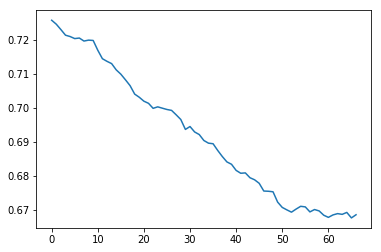

In [54]:
plt.plot(vals)

In [65]:
n_epochs = 5000
print('>> error ', np.sum(np.sum((targetW - bm.W)**2)) )
for epoch_n in range(n_epochs):
    print('====== epoch ', epoch_n, '=======')
    bm.train( X, 0.001, 20, annealing_schedule )
    W_history.append(np.copy(bm.W))
    vals.append(np.sum(np.sum((targetW - bm.W)**2)))
    print('>> error ', np.sum(np.sum((targetW - bm.W)**2)) )


>> error  0.648576332092
====== epoch  0 =======
>> error  0.648637457676
====== epoch  1 =======
>> error  0.648571640468
====== epoch  2 =======
>> error  0.648281647628
====== epoch  3 =======
>> error  0.648281175318
====== epoch  4 =======
>> error  0.648251332712
====== epoch  5 =======
>> error  0.648239977933
====== epoch  6 =======
>> error  0.648204294784
====== epoch  7 =======
>> error  0.648142840267
====== epoch  8 =======
>> error  0.648107600456
====== epoch  9 =======
>> error  0.648165462531
====== epoch  10 =======
>> error  0.648127225458
====== epoch  11 =======
>> error  0.64816965688
====== epoch  12 =======
>> error  0.648206270923
====== epoch  13 =======
>> error  0.648220783193
====== epoch  14 =======
>> error  0.648164336289
====== epoch  15 =======
>> error  0.648066450342
====== epoch  16 =======
>> error  0.64794151292
====== epoch  17 =======
>> error  0.647825131685
====== epoch  18 =======
>> error  0.647771983402
====== epoch  19 =======
>> error  0.

>> error  0.637999028309
====== epoch  164 =======
>> error  0.637926094947
====== epoch  165 =======
>> error  0.637905908052
====== epoch  166 =======
>> error  0.637804848015
====== epoch  167 =======
>> error  0.637773771177
====== epoch  168 =======
>> error  0.63788055183
====== epoch  169 =======
>> error  0.637838723958
====== epoch  170 =======
>> error  0.637786975576
====== epoch  171 =======
>> error  0.63773403565
====== epoch  172 =======
>> error  0.63764870338
====== epoch  173 =======
>> error  0.637666732316
====== epoch  174 =======
>> error  0.637612588717
====== epoch  175 =======
>> error  0.637476206221
====== epoch  176 =======
>> error  0.637434600888
====== epoch  177 =======
>> error  0.637265910073
====== epoch  178 =======
>> error  0.637244730815
====== epoch  179 =======
>> error  0.637146112648
====== epoch  180 =======
>> error  0.637153970351
====== epoch  181 =======
>> error  0.637048120261
====== epoch  182 =======
>> error  0.636913008973
====== ep

>> error  0.629105340725
====== epoch  325 =======
>> error  0.629067365037
====== epoch  326 =======
>> error  0.629062569445
====== epoch  327 =======
>> error  0.629114707498
====== epoch  328 =======
>> error  0.629094510039
====== epoch  329 =======
>> error  0.629152222854
====== epoch  330 =======
>> error  0.629136209344
====== epoch  331 =======
>> error  0.629147193742
====== epoch  332 =======
>> error  0.628973940353
====== epoch  333 =======
>> error  0.628929372327
====== epoch  334 =======
>> error  0.62895484012
====== epoch  335 =======
>> error  0.628883636872
====== epoch  336 =======
>> error  0.62876175179
====== epoch  337 =======
>> error  0.628871754913
====== epoch  338 =======
>> error  0.628826851343
====== epoch  339 =======
>> error  0.628778295945
====== epoch  340 =======
>> error  0.628845438349
====== epoch  341 =======
>> error  0.62878910712
====== epoch  342 =======
>> error  0.628768876143
====== epoch  343 =======
>> error  0.628714789467
====== ep

>> error  0.622340744775
====== epoch  486 =======
>> error  0.622280375297
====== epoch  487 =======
>> error  0.622104565063
====== epoch  488 =======
>> error  0.622031139296
====== epoch  489 =======
>> error  0.621864782867
====== epoch  490 =======
>> error  0.621958921095
====== epoch  491 =======
>> error  0.621996194428
====== epoch  492 =======
>> error  0.622000449493
====== epoch  493 =======
>> error  0.62187396505
====== epoch  494 =======
>> error  0.621904933167
====== epoch  495 =======
>> error  0.621843235542
====== epoch  496 =======
>> error  0.621818220009
====== epoch  497 =======
>> error  0.621960513094
====== epoch  498 =======
>> error  0.621862432832
====== epoch  499 =======
>> error  0.621791235905
====== epoch  500 =======
>> error  0.621909604282
====== epoch  501 =======
>> error  0.621916400891
====== epoch  502 =======
>> error  0.621906259855
====== epoch  503 =======
>> error  0.621809587605
====== epoch  504 =======
>> error  0.621726881754
====== 

>> error  0.613809078159
====== epoch  648 =======
>> error  0.613665427645
====== epoch  649 =======
>> error  0.61356507666
====== epoch  650 =======
>> error  0.613334362915
====== epoch  651 =======
>> error  0.613312231666
====== epoch  652 =======
>> error  0.613164212152
====== epoch  653 =======
>> error  0.613035321455
====== epoch  654 =======
>> error  0.612967258461
====== epoch  655 =======
>> error  0.613029340386
====== epoch  656 =======
>> error  0.61289555202
====== epoch  657 =======
>> error  0.612804216768
====== epoch  658 =======
>> error  0.612883491944
====== epoch  659 =======
>> error  0.612798012352
====== epoch  660 =======
>> error  0.612853188547
====== epoch  661 =======
>> error  0.61282334492
====== epoch  662 =======
>> error  0.612915964856
====== epoch  663 =======
>> error  0.612849089604
====== epoch  664 =======
>> error  0.612828107336
====== epoch  665 =======
>> error  0.612860200644
====== epoch  666 =======
>> error  0.61281209704
====== epo

>> error  0.607122054773
====== epoch  810 =======
>> error  0.607071883876
====== epoch  811 =======
>> error  0.606945835369
====== epoch  812 =======
>> error  0.60684733099
====== epoch  813 =======
>> error  0.606679043698
====== epoch  814 =======
>> error  0.606669675535
====== epoch  815 =======
>> error  0.606573255662
====== epoch  816 =======
>> error  0.606519807715
====== epoch  817 =======
>> error  0.606516114113
====== epoch  818 =======
>> error  0.606414463999
====== epoch  819 =======
>> error  0.606293821299
====== epoch  820 =======
>> error  0.606211782199
====== epoch  821 =======
>> error  0.606173436018
====== epoch  822 =======
>> error  0.606082182581
====== epoch  823 =======
>> error  0.605981305168
====== epoch  824 =======
>> error  0.605973081243
====== epoch  825 =======
>> error  0.605951820256
====== epoch  826 =======
>> error  0.605997799428
====== epoch  827 =======
>> error  0.605921524737
====== epoch  828 =======
>> error  0.605985045312
====== 

>> error  0.601315000359
====== epoch  971 =======
>> error  0.601152914041
====== epoch  972 =======
>> error  0.601161910072
====== epoch  973 =======
>> error  0.601133064921
====== epoch  974 =======
>> error  0.601140401564
====== epoch  975 =======
>> error  0.601122686243
====== epoch  976 =======
>> error  0.601060697632
====== epoch  977 =======
>> error  0.600898195313
====== epoch  978 =======
>> error  0.600968650901
====== epoch  979 =======
>> error  0.600838563501
====== epoch  980 =======
>> error  0.600664273677
====== epoch  981 =======
>> error  0.600636937823
====== epoch  982 =======
>> error  0.600576068921
====== epoch  983 =======
>> error  0.600514871596
====== epoch  984 =======
>> error  0.600447440247
====== epoch  985 =======
>> error  0.600370914153
====== epoch  986 =======
>> error  0.600370640656
====== epoch  987 =======
>> error  0.600483764576
====== epoch  988 =======
>> error  0.600375616564
====== epoch  989 =======
>> error  0.60031522082
====== 

>> error  0.595263664341
====== epoch  1130 =======
>> error  0.595190514351
====== epoch  1131 =======
>> error  0.595068402141
====== epoch  1132 =======
>> error  0.595119086006
====== epoch  1133 =======
>> error  0.595184820406
====== epoch  1134 =======
>> error  0.595226089963
====== epoch  1135 =======
>> error  0.595151368857
====== epoch  1136 =======
>> error  0.595001606281
====== epoch  1137 =======
>> error  0.595024675149
====== epoch  1138 =======
>> error  0.594906820893
====== epoch  1139 =======
>> error  0.594934028036
====== epoch  1140 =======
>> error  0.594769534399
====== epoch  1141 =======
>> error  0.594757962589
====== epoch  1142 =======
>> error  0.59467341707
====== epoch  1143 =======
>> error  0.594575413758
====== epoch  1144 =======
>> error  0.594551259591
====== epoch  1145 =======
>> error  0.594391351609
====== epoch  1146 =======
>> error  0.594261331909
====== epoch  1147 =======
>> error  0.594216023438
====== epoch  1148 =======
>> error  0.5

>> error  0.591481647409
====== epoch  1288 =======
>> error  0.591436699936
====== epoch  1289 =======
>> error  0.591479542919
====== epoch  1290 =======
>> error  0.59156428583
====== epoch  1291 =======
>> error  0.591580859316
====== epoch  1292 =======
>> error  0.591590394781
====== epoch  1293 =======
>> error  0.591604752081
====== epoch  1294 =======
>> error  0.591445672569
====== epoch  1295 =======
>> error  0.591514408253
====== epoch  1296 =======
>> error  0.591399979335
====== epoch  1297 =======
>> error  0.591431434347
====== epoch  1298 =======
>> error  0.591350205679
====== epoch  1299 =======
>> error  0.591295620238
====== epoch  1300 =======
>> error  0.591328892368
====== epoch  1301 =======
>> error  0.591267659375
====== epoch  1302 =======
>> error  0.59121027587
====== epoch  1303 =======
>> error  0.591186630262
====== epoch  1304 =======
>> error  0.591212872762
====== epoch  1305 =======
>> error  0.591062990843
====== epoch  1306 =======
>> error  0.59

>> error  0.588467294657
====== epoch  1446 =======
>> error  0.588335051378
====== epoch  1447 =======
>> error  0.588338439414
====== epoch  1448 =======
>> error  0.588319467265
====== epoch  1449 =======
>> error  0.588259816315
====== epoch  1450 =======
>> error  0.588271801212
====== epoch  1451 =======
>> error  0.588220378928
====== epoch  1452 =======
>> error  0.588286842871
====== epoch  1453 =======
>> error  0.588290904501
====== epoch  1454 =======
>> error  0.588292723043
====== epoch  1455 =======
>> error  0.588423525403
====== epoch  1456 =======
>> error  0.588402138824
====== epoch  1457 =======
>> error  0.58846400424
====== epoch  1458 =======
>> error  0.588451388909
====== epoch  1459 =======
>> error  0.588342001043
====== epoch  1460 =======
>> error  0.588313995712
====== epoch  1461 =======
>> error  0.588320735737
====== epoch  1462 =======
>> error  0.588416305352
====== epoch  1463 =======
>> error  0.588315473154
====== epoch  1464 =======
>> error  0.5

>> error  0.584733156286
====== epoch  1604 =======
>> error  0.584655414892
====== epoch  1605 =======
>> error  0.584576722907
====== epoch  1606 =======
>> error  0.584552439352
====== epoch  1607 =======
>> error  0.584515620654
====== epoch  1608 =======
>> error  0.584548561231
====== epoch  1609 =======
>> error  0.584613707525
====== epoch  1610 =======
>> error  0.584598564581
====== epoch  1611 =======
>> error  0.584612539269
====== epoch  1612 =======
>> error  0.584561913635
====== epoch  1613 =======
>> error  0.584646330645
====== epoch  1614 =======
>> error  0.584652133321
====== epoch  1615 =======
>> error  0.584554078623
====== epoch  1616 =======
>> error  0.584551978995
====== epoch  1617 =======
>> error  0.5845399536
====== epoch  1618 =======
>> error  0.584515767093
====== epoch  1619 =======
>> error  0.584495760436
====== epoch  1620 =======
>> error  0.584372218201
====== epoch  1621 =======
>> error  0.584410220514
====== epoch  1622 =======
>> error  0.58

>> error  0.580777852056
====== epoch  1762 =======
>> error  0.580724248314
====== epoch  1763 =======
>> error  0.580755583433
====== epoch  1764 =======
>> error  0.580801742932
====== epoch  1765 =======
>> error  0.580732337147
====== epoch  1766 =======
>> error  0.580698666634
====== epoch  1767 =======
>> error  0.580738789246
====== epoch  1768 =======
>> error  0.580608246236
====== epoch  1769 =======
>> error  0.580520285274
====== epoch  1770 =======
>> error  0.580490422347
====== epoch  1771 =======
>> error  0.580543140699
====== epoch  1772 =======
>> error  0.580531322415
====== epoch  1773 =======
>> error  0.580504754285
====== epoch  1774 =======
>> error  0.580446558947
====== epoch  1775 =======
>> error  0.580462217192
====== epoch  1776 =======
>> error  0.580394194769
====== epoch  1777 =======
>> error  0.580278090561
====== epoch  1778 =======
>> error  0.580189464114
====== epoch  1779 =======
>> error  0.58019303179
====== epoch  1780 =======
>> error  0.5

>> error  0.576441530179
====== epoch  1920 =======
>> error  0.576445768914
====== epoch  1921 =======
>> error  0.576424042715
====== epoch  1922 =======
>> error  0.576362124633
====== epoch  1923 =======
>> error  0.576375561318
====== epoch  1924 =======
>> error  0.576338856997
====== epoch  1925 =======
>> error  0.576467890776
====== epoch  1926 =======
>> error  0.57644625061
====== epoch  1927 =======
>> error  0.576419430383
====== epoch  1928 =======
>> error  0.57642827429
====== epoch  1929 =======
>> error  0.576528550801
====== epoch  1930 =======
>> error  0.576444909087
====== epoch  1931 =======
>> error  0.576411838562
====== epoch  1932 =======
>> error  0.576346682726
====== epoch  1933 =======
>> error  0.576383369003
====== epoch  1934 =======
>> error  0.576438436549
====== epoch  1935 =======
>> error  0.576480544272
====== epoch  1936 =======
>> error  0.576210298421
====== epoch  1937 =======
>> error  0.576175936908
====== epoch  1938 =======
>> error  0.57

>> error  0.573549529262
====== epoch  2078 =======
>> error  0.573487276794
====== epoch  2079 =======
>> error  0.573517395398
====== epoch  2080 =======
>> error  0.573498036432
====== epoch  2081 =======
>> error  0.57346113839
====== epoch  2082 =======
>> error  0.573513473337
====== epoch  2083 =======
>> error  0.573443152252
====== epoch  2084 =======
>> error  0.573370669454
====== epoch  2085 =======
>> error  0.573415792016
====== epoch  2086 =======
>> error  0.573425947964
====== epoch  2087 =======
>> error  0.573440361386
====== epoch  2088 =======
>> error  0.573438369641
====== epoch  2089 =======
>> error  0.573380545577
====== epoch  2090 =======
>> error  0.573299740361
====== epoch  2091 =======
>> error  0.573443338343
====== epoch  2092 =======
>> error  0.573453921411
====== epoch  2093 =======
>> error  0.573440698272
====== epoch  2094 =======
>> error  0.573311769063
====== epoch  2095 =======
>> error  0.573352983594
====== epoch  2096 =======
>> error  0.5

>> error  0.57031518456
====== epoch  2236 =======
>> error  0.570188749881
====== epoch  2237 =======
>> error  0.570182619563
====== epoch  2238 =======
>> error  0.57020172775
====== epoch  2239 =======
>> error  0.57006044486
====== epoch  2240 =======
>> error  0.569988621859
====== epoch  2241 =======
>> error  0.569980152406
====== epoch  2242 =======
>> error  0.569926956307
====== epoch  2243 =======
>> error  0.569899443936
====== epoch  2244 =======
>> error  0.569926962907
====== epoch  2245 =======
>> error  0.569908897922
====== epoch  2246 =======
>> error  0.569810284931
====== epoch  2247 =======
>> error  0.569769796148
====== epoch  2248 =======
>> error  0.569561061216
====== epoch  2249 =======
>> error  0.569584836336
====== epoch  2250 =======
>> error  0.569522578054
====== epoch  2251 =======
>> error  0.569550816575
====== epoch  2252 =======
>> error  0.569715416845
====== epoch  2253 =======
>> error  0.569691824855
====== epoch  2254 =======
>> error  0.569

>> error  0.567163181
====== epoch  2394 =======
>> error  0.567223372484
====== epoch  2395 =======
>> error  0.567184865637
====== epoch  2396 =======
>> error  0.567214602318
====== epoch  2397 =======
>> error  0.567211984711
====== epoch  2398 =======
>> error  0.567204398089
====== epoch  2399 =======
>> error  0.567269074511
====== epoch  2400 =======
>> error  0.567350208597
====== epoch  2401 =======
>> error  0.567395574521
====== epoch  2402 =======
>> error  0.567453597283
====== epoch  2403 =======
>> error  0.567427911896
====== epoch  2404 =======
>> error  0.567444556109
====== epoch  2405 =======
>> error  0.567493580421
====== epoch  2406 =======
>> error  0.567451792091
====== epoch  2407 =======
>> error  0.567495227954
====== epoch  2408 =======
>> error  0.567550380662
====== epoch  2409 =======
>> error  0.567523502295
====== epoch  2410 =======
>> error  0.56748727328
====== epoch  2411 =======
>> error  0.567391496293
====== epoch  2412 =======
>> error  0.5674

>> error  0.565383035046
====== epoch  2553 =======
>> error  0.56539813409
====== epoch  2554 =======
>> error  0.565188668051
====== epoch  2555 =======
>> error  0.565157360734
====== epoch  2556 =======
>> error  0.565234455554
====== epoch  2557 =======
>> error  0.565127910316
====== epoch  2558 =======
>> error  0.565104085114
====== epoch  2559 =======
>> error  0.565141669422
====== epoch  2560 =======
>> error  0.565138996789
====== epoch  2561 =======
>> error  0.565063411837
====== epoch  2562 =======
>> error  0.564994041705
====== epoch  2563 =======
>> error  0.564886812943
====== epoch  2564 =======
>> error  0.564913685731
====== epoch  2565 =======
>> error  0.564907543041
====== epoch  2566 =======
>> error  0.564945083878
====== epoch  2567 =======
>> error  0.564918779693
====== epoch  2568 =======
>> error  0.564904689687
====== epoch  2569 =======
>> error  0.564813235552
====== epoch  2570 =======
>> error  0.564815250598
====== epoch  2571 =======
>> error  0.5

>> error  0.564174589124
====== epoch  2711 =======
>> error  0.56420167303
====== epoch  2712 =======
>> error  0.56420349933
====== epoch  2713 =======
>> error  0.564105257767
====== epoch  2714 =======
>> error  0.564117832402
====== epoch  2715 =======
>> error  0.56408822022
====== epoch  2716 =======
>> error  0.564082193279
====== epoch  2717 =======
>> error  0.564083991683
====== epoch  2718 =======
>> error  0.563997526693
====== epoch  2719 =======
>> error  0.5640069364
====== epoch  2720 =======
>> error  0.563981889734
====== epoch  2721 =======
>> error  0.563986845544
====== epoch  2722 =======
>> error  0.563998976392
====== epoch  2723 =======
>> error  0.564170592961
====== epoch  2724 =======
>> error  0.564119297914
====== epoch  2725 =======
>> error  0.564191614356
====== epoch  2726 =======
>> error  0.564183077251
====== epoch  2727 =======
>> error  0.564213440596
====== epoch  2728 =======
>> error  0.564198604191
====== epoch  2729 =======
>> error  0.56429

>> error  0.5625328273
====== epoch  2869 =======
>> error  0.562622306395
====== epoch  2870 =======
>> error  0.56254645605
====== epoch  2871 =======
>> error  0.562486216103
====== epoch  2872 =======
>> error  0.562474616082
====== epoch  2873 =======
>> error  0.562450959917
====== epoch  2874 =======
>> error  0.562300646993
====== epoch  2875 =======
>> error  0.562423088209
====== epoch  2876 =======
>> error  0.562396672435
====== epoch  2877 =======
>> error  0.562399594882
====== epoch  2878 =======
>> error  0.562333549359
====== epoch  2879 =======
>> error  0.562388793534
====== epoch  2880 =======
>> error  0.562339628448
====== epoch  2881 =======
>> error  0.56242444384
====== epoch  2882 =======
>> error  0.562359363063
====== epoch  2883 =======
>> error  0.562476138378
====== epoch  2884 =======
>> error  0.562468328439
====== epoch  2885 =======
>> error  0.56243693388
====== epoch  2886 =======
>> error  0.562518299388
====== epoch  2887 =======
>> error  0.56256

>> error  0.560924661922
====== epoch  3027 =======
>> error  0.560953156145
====== epoch  3028 =======
>> error  0.560994930983
====== epoch  3029 =======
>> error  0.560853324748
====== epoch  3030 =======
>> error  0.56084239657
====== epoch  3031 =======
>> error  0.560800913891
====== epoch  3032 =======
>> error  0.560780922939
====== epoch  3033 =======
>> error  0.560673857397
====== epoch  3034 =======
>> error  0.560806556233
====== epoch  3035 =======
>> error  0.560865497544
====== epoch  3036 =======
>> error  0.560832698288
====== epoch  3037 =======
>> error  0.560843990587
====== epoch  3038 =======
>> error  0.560915133903
====== epoch  3039 =======
>> error  0.56094585735
====== epoch  3040 =======
>> error  0.560953014595
====== epoch  3041 =======
>> error  0.560959092076
====== epoch  3042 =======
>> error  0.56091322692
====== epoch  3043 =======
>> error  0.560989523449
====== epoch  3044 =======
>> error  0.560984485259
====== epoch  3045 =======
>> error  0.561

>> error  0.55938870704
====== epoch  3185 =======
>> error  0.559412258748
====== epoch  3186 =======
>> error  0.559353028164
====== epoch  3187 =======
>> error  0.559333549705
====== epoch  3188 =======
>> error  0.559277505585
====== epoch  3189 =======
>> error  0.559348537955
====== epoch  3190 =======
>> error  0.559409503915
====== epoch  3191 =======
>> error  0.559390441986
====== epoch  3192 =======
>> error  0.559309282664
====== epoch  3193 =======
>> error  0.559347939271
====== epoch  3194 =======
>> error  0.559404442712
====== epoch  3195 =======
>> error  0.559503728141
====== epoch  3196 =======
>> error  0.559392010404
====== epoch  3197 =======
>> error  0.559327480501
====== epoch  3198 =======
>> error  0.559294492172
====== epoch  3199 =======
>> error  0.559293041688
====== epoch  3200 =======
>> error  0.559355782013
====== epoch  3201 =======
>> error  0.559413298784
====== epoch  3202 =======
>> error  0.55945990556
====== epoch  3203 =======
>> error  0.55

>> error  0.557972060943
====== epoch  3343 =======
>> error  0.557910057939
====== epoch  3344 =======
>> error  0.557872641813
====== epoch  3345 =======
>> error  0.557943446028
====== epoch  3346 =======
>> error  0.557856328229
====== epoch  3347 =======
>> error  0.557818025061
====== epoch  3348 =======
>> error  0.557725429031
====== epoch  3349 =======
>> error  0.557621562208
====== epoch  3350 =======
>> error  0.557596377424
====== epoch  3351 =======
>> error  0.557570505028
====== epoch  3352 =======
>> error  0.557543821446
====== epoch  3353 =======
>> error  0.557516906256
====== epoch  3354 =======
>> error  0.557516537437
====== epoch  3355 =======
>> error  0.557583106781
====== epoch  3356 =======
>> error  0.557662581701
====== epoch  3357 =======
>> error  0.55780154679
====== epoch  3358 =======
>> error  0.557786139895
====== epoch  3359 =======
>> error  0.557685020231
====== epoch  3360 =======
>> error  0.557727347982
====== epoch  3361 =======
>> error  0.5

>> error  0.555745421714
====== epoch  3501 =======
>> error  0.555622718531
====== epoch  3502 =======
>> error  0.55575560339
====== epoch  3503 =======
>> error  0.555785373776
====== epoch  3504 =======
>> error  0.555721410388
====== epoch  3505 =======
>> error  0.555800406883
====== epoch  3506 =======
>> error  0.555795112454
====== epoch  3507 =======
>> error  0.555863130107
====== epoch  3508 =======
>> error  0.555877830077
====== epoch  3509 =======
>> error  0.555779748332
====== epoch  3510 =======
>> error  0.555843982945
====== epoch  3511 =======
>> error  0.555866674811
====== epoch  3512 =======
>> error  0.555851072861
====== epoch  3513 =======
>> error  0.555899650867
====== epoch  3514 =======
>> error  0.555841311153
====== epoch  3515 =======
>> error  0.555849116528
====== epoch  3516 =======
>> error  0.555877335231
====== epoch  3517 =======
>> error  0.55577148444
====== epoch  3518 =======
>> error  0.555795970394
====== epoch  3519 =======
>> error  0.55

>> error  0.554477437936
====== epoch  3659 =======
>> error  0.554394622025
====== epoch  3660 =======
>> error  0.554442174761
====== epoch  3661 =======
>> error  0.554450076755
====== epoch  3662 =======
>> error  0.554413337288
====== epoch  3663 =======
>> error  0.55425445663
====== epoch  3664 =======
>> error  0.554261509537
====== epoch  3665 =======
>> error  0.554117926459
====== epoch  3666 =======
>> error  0.554067538486
====== epoch  3667 =======
>> error  0.554089549926
====== epoch  3668 =======
>> error  0.553990172047
====== epoch  3669 =======
>> error  0.554039486494
====== epoch  3670 =======
>> error  0.554178680857
====== epoch  3671 =======
>> error  0.554292084613
====== epoch  3672 =======
>> error  0.554291173864
====== epoch  3673 =======
>> error  0.554260487802
====== epoch  3674 =======
>> error  0.554232858747
====== epoch  3675 =======
>> error  0.554244279613
====== epoch  3676 =======
>> error  0.55428630698
====== epoch  3677 =======
>> error  0.55

>> error  0.553058159367
====== epoch  3817 =======
>> error  0.552973035595
====== epoch  3818 =======
>> error  0.55304221628
====== epoch  3819 =======
>> error  0.553032349882
====== epoch  3820 =======
>> error  0.552885029849
====== epoch  3821 =======
>> error  0.552821840407
====== epoch  3822 =======
>> error  0.552763826134
====== epoch  3823 =======
>> error  0.552681614575
====== epoch  3824 =======
>> error  0.552714642119
====== epoch  3825 =======
>> error  0.552733293386
====== epoch  3826 =======
>> error  0.552755153825
====== epoch  3827 =======
>> error  0.552730504982
====== epoch  3828 =======
>> error  0.552696802154
====== epoch  3829 =======
>> error  0.552695410354
====== epoch  3830 =======
>> error  0.552774299351
====== epoch  3831 =======
>> error  0.552715756052
====== epoch  3832 =======
>> error  0.552717788292
====== epoch  3833 =======
>> error  0.552708311682
====== epoch  3834 =======
>> error  0.552656144659
====== epoch  3835 =======
>> error  0.5

>> error  0.55110747273
====== epoch  3975 =======
>> error  0.551007451655
====== epoch  3976 =======
>> error  0.551034566392
====== epoch  3977 =======
>> error  0.550956563469
====== epoch  3978 =======
>> error  0.551001604447
====== epoch  3979 =======
>> error  0.550824254844
====== epoch  3980 =======
>> error  0.550886287949
====== epoch  3981 =======
>> error  0.550943910264
====== epoch  3982 =======
>> error  0.551051736959
====== epoch  3983 =======
>> error  0.551069087029
====== epoch  3984 =======
>> error  0.551175629215
====== epoch  3985 =======
>> error  0.551101160545
====== epoch  3986 =======
>> error  0.551123351663
====== epoch  3987 =======
>> error  0.551124874353
====== epoch  3988 =======
>> error  0.551108230454
====== epoch  3989 =======
>> error  0.551041861176
====== epoch  3990 =======
>> error  0.551116005758
====== epoch  3991 =======
>> error  0.551075004499
====== epoch  3992 =======
>> error  0.5511284217
====== epoch  3993 =======
>> error  0.551

>> error  0.551116681013
====== epoch  4133 =======
>> error  0.551133300305
====== epoch  4134 =======
>> error  0.55109774879
====== epoch  4135 =======
>> error  0.551076259952
====== epoch  4136 =======
>> error  0.550937459057
====== epoch  4137 =======
>> error  0.551038353901
====== epoch  4138 =======
>> error  0.551030993558
====== epoch  4139 =======
>> error  0.551061257893
====== epoch  4140 =======
>> error  0.551165833176
====== epoch  4141 =======
>> error  0.55113564065
====== epoch  4142 =======
>> error  0.551084769464
====== epoch  4143 =======
>> error  0.551123033892
====== epoch  4144 =======
>> error  0.551166849549
====== epoch  4145 =======
>> error  0.551049272923
====== epoch  4146 =======
>> error  0.551160675538
====== epoch  4147 =======
>> error  0.55108574918
====== epoch  4148 =======
>> error  0.551090294131
====== epoch  4149 =======
>> error  0.551169730926
====== epoch  4150 =======
>> error  0.551031115402
====== epoch  4151 =======
>> error  0.550

>> error  0.551105840351
====== epoch  4291 =======
>> error  0.551123727853
====== epoch  4292 =======
>> error  0.5511169453
====== epoch  4293 =======
>> error  0.551106099556
====== epoch  4294 =======
>> error  0.551114623206
====== epoch  4295 =======
>> error  0.551133314081
====== epoch  4296 =======
>> error  0.551191718172
====== epoch  4297 =======
>> error  0.551310820056
====== epoch  4298 =======
>> error  0.551388261294
====== epoch  4299 =======
>> error  0.551471769454
====== epoch  4300 =======
>> error  0.551429107469
====== epoch  4301 =======
>> error  0.551366304657
====== epoch  4302 =======
>> error  0.551433996934
====== epoch  4303 =======
>> error  0.551486792591
====== epoch  4304 =======
>> error  0.551581937693
====== epoch  4305 =======
>> error  0.55161406051
====== epoch  4306 =======
>> error  0.551721599063
====== epoch  4307 =======
>> error  0.551639372947
====== epoch  4308 =======
>> error  0.551627288656
====== epoch  4309 =======
>> error  0.551

>> error  0.552470486943
====== epoch  4449 =======
>> error  0.552441786561
====== epoch  4450 =======
>> error  0.552345583123
====== epoch  4451 =======
>> error  0.55236417929
====== epoch  4452 =======
>> error  0.552393016172
====== epoch  4453 =======
>> error  0.552456131669
====== epoch  4454 =======
>> error  0.552475114263
====== epoch  4455 =======
>> error  0.552468744843
====== epoch  4456 =======
>> error  0.552502873652
====== epoch  4457 =======
>> error  0.552539430071
====== epoch  4458 =======
>> error  0.55262614844
====== epoch  4459 =======
>> error  0.55253667843
====== epoch  4460 =======
>> error  0.552660986336
====== epoch  4461 =======
>> error  0.552707371922
====== epoch  4462 =======
>> error  0.552592189492
====== epoch  4463 =======
>> error  0.552675633185
====== epoch  4464 =======
>> error  0.552695873007
====== epoch  4465 =======
>> error  0.552646381432
====== epoch  4466 =======
>> error  0.552577691921
====== epoch  4467 =======
>> error  0.552

>> error  0.552210862149
====== epoch  4607 =======
>> error  0.552268726997
====== epoch  4608 =======
>> error  0.552263356929
====== epoch  4609 =======
>> error  0.552247354218
====== epoch  4610 =======
>> error  0.552181565224
====== epoch  4611 =======
>> error  0.552041430264
====== epoch  4612 =======
>> error  0.552076433415
====== epoch  4613 =======
>> error  0.552135833874
====== epoch  4614 =======
>> error  0.552092434324
====== epoch  4615 =======
>> error  0.551992340023
====== epoch  4616 =======
>> error  0.551941812527
====== epoch  4617 =======
>> error  0.551894050096
====== epoch  4618 =======
>> error  0.55200254454
====== epoch  4619 =======
>> error  0.551996856782
====== epoch  4620 =======
>> error  0.551914898361
====== epoch  4621 =======
>> error  0.551957730555
====== epoch  4622 =======
>> error  0.551969837641
====== epoch  4623 =======
>> error  0.552063261227
====== epoch  4624 =======
>> error  0.552029076651
====== epoch  4625 =======
>> error  0.5

>> error  0.55107395272
====== epoch  4765 =======
>> error  0.551033823264
====== epoch  4766 =======
>> error  0.55103386932
====== epoch  4767 =======
>> error  0.55089005485
====== epoch  4768 =======
>> error  0.550869043434
====== epoch  4769 =======
>> error  0.550858574289
====== epoch  4770 =======
>> error  0.55084538372
====== epoch  4771 =======
>> error  0.550798779728
====== epoch  4772 =======
>> error  0.550737501732
====== epoch  4773 =======
>> error  0.550781295933
====== epoch  4774 =======
>> error  0.550731432833
====== epoch  4775 =======
>> error  0.550727802328
====== epoch  4776 =======
>> error  0.550750987503
====== epoch  4777 =======
>> error  0.550798097306
====== epoch  4778 =======
>> error  0.550736391754
====== epoch  4779 =======
>> error  0.550740292906
====== epoch  4780 =======
>> error  0.550666988461
====== epoch  4781 =======
>> error  0.550693990026
====== epoch  4782 =======
>> error  0.550685974459
====== epoch  4783 =======
>> error  0.5507

>> error  0.550192982586
====== epoch  4923 =======
>> error  0.550136652622
====== epoch  4924 =======
>> error  0.550212453023
====== epoch  4925 =======
>> error  0.550286619956
====== epoch  4926 =======
>> error  0.550226227889
====== epoch  4927 =======
>> error  0.550240687924
====== epoch  4928 =======
>> error  0.550254314051
====== epoch  4929 =======
>> error  0.55025869748
====== epoch  4930 =======
>> error  0.550312574039
====== epoch  4931 =======
>> error  0.550269091999
====== epoch  4932 =======
>> error  0.550230305191
====== epoch  4933 =======
>> error  0.550243830705
====== epoch  4934 =======
>> error  0.550240488961
====== epoch  4935 =======
>> error  0.550259383688
====== epoch  4936 =======
>> error  0.550184061934
====== epoch  4937 =======
>> error  0.55018346714
====== epoch  4938 =======
>> error  0.55007331253
====== epoch  4939 =======
>> error  0.550090907406
====== epoch  4940 =======
>> error  0.550086282755
====== epoch  4941 =======
>> error  0.550

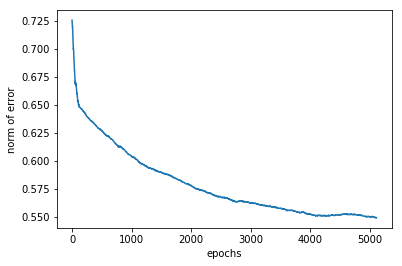

In [76]:
plt.plot(vals)
plt.xlabel('epochs')
plt.ylabel('norm of error')
plt.savefig('BM_convergence.png')

In [69]:
oldW = bm.W
print(bm.W)
print(targetW)
print(W_history[1])

[[ 0.          0.03444346  0.28341712 -0.02084778]
 [ 0.03444346  0.          0.20673488  0.11281791]
 [ 0.28341712  0.20673488  0.          0.00827804]
 [-0.02084778  0.11281791  0.00827804  0.        ]]
[[ 0.   0.   0.6  0. ]
 [ 0.   0.   0.   0.3]
 [ 0.6  0.   0.  -0.3]
 [ 0.   0.3 -0.3  0. ]]
[[ 0.         -0.05466654  0.18886112 -0.10741678]
 [-0.05466654  0.          0.24291988  0.14834591]
 [ 0.18886112  0.24291988  0.          0.01191704]
 [-0.10741678  0.14834591  0.01191704  0.        ]]


In [70]:
len(W_history)/16

319.875

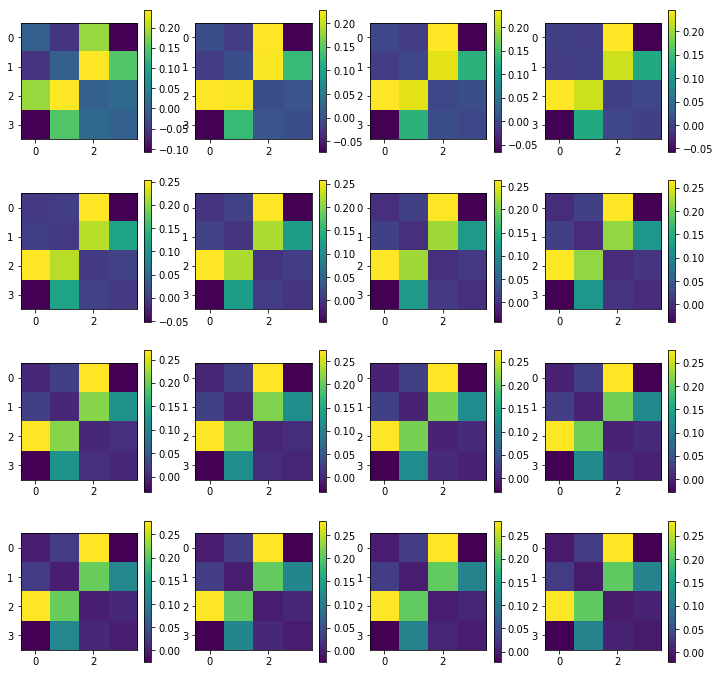

In [71]:
plt.figure(figsize=(12,12))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*i + j + 1)
        plt.imshow(W_history[320*(4*i + j) + 1])
        plt.colorbar()
        

In [ ]:
n_epochs = 20
for epoch_n in range(n_epochs):
    print('====== epoch ', epoch_n, '=======')
    bm.train( X, 0.1, 201 )
    W_history.append(np.copy(bm.W))

In [ ]:
plt.figure(figsize=(12,15))
for i in range(4):
    for j in range(5):
        plt.subplot(4,5,5*i + j + 1)
        plt.imshow(W_history[5*i + j + 17])
        plt.colorbar()

In [ ]:
len(W_history)

In [72]:
print(marginals)
print( check_sampling_procedure(bm, 1000, annealing_schedule, np.array([1,1]).reshape(2,1), 20) )

[ 0.15079361  0.47831396  0.37089243]
(array([160, 496, 344]), array([-0.5,  0.5,  1.5,  2.5]))


In [62]:
bm2 = BM(4,2)

In [63]:
print(marginals)
print( check_sampling_procedure(bm2, 1000, annealing_schedule, np.array([1,1]).reshape(2,1), 20) )

[ 0.15079361  0.47831396  0.37089243]
(array([289, 512, 199]), array([-0.5,  0.5,  1.5,  2.5]))
